# Dog Breed Classifier Using AWS

in this notebook we are going to build and image classifier model using pre-trained model, we have a data of 133 dog breeds. the task is creating a model that predict dog breed using its image. the whole process is done on AWS sagemaker

**Steps**
- download the data set using its link
- upload the data to S3
- write python script `hpo.py` that train the model using pytorch
- create hyperparameter tuner to train the model on differnt hyperparameters to get the most accurate model
- get the hyperparameters that will create the most powerfull model
- create dubuger and profiler
- train the model using hyperparameters gained from the tuner
- infernce some data

In [1]:
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 27.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.83 requires botocore==1.27.82, but you have botocore 1.27.92 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.92 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
# import libararies 
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)


from sagemaker.debugger import (
    Rule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    ProfilerRule,
    ProfilerConfig,
    FrameworkProfile
)

from sagemaker import get_execution_role, Session
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

import boto3
import smdebug
import os


from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


[2022-10-22 14:06:42.343 ip-172-16-99-96.ec2.internal:15780 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


Matplotlib is building the font cache; this may take a moment.


## Dataset
the data is about 133 dog breed

In [4]:
# Fetch the data from the internet

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip 

--2022-10-10 13:06:12--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.144
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

100%[====================================>] 1,132,023,110 20.3MB/s   in 43s    

2022-10-10 13:06:55 (25.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [2]:
# information about the sagemaker session

session = Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-314880696898
AWS Region: us-east-1
RoleArn: arn:aws:iam::314880696898:role/service-role/AmazonSageMaker-ExecutionRole-20221010T143116


In [5]:
# commands to upload data to s3
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages --quiet


## Hyperparameter Tuning

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "learn-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64]),
    "epochs": IntegerParameter(5, 20),
}

objective_metric_name = "average test loss"
objective_type = "Maximize"
metric_definitions = [{"Name": "average test loss", "Regex": "Acc: ([0-9\\.]+)"}]

In [11]:
#Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=4,
    instance_type="ml.m5.4xlarge"

)

# create tuner 
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [13]:
# Fit your HP Tuner
train_data = "s3://{}/{}/".format(bucket, "dogImages")
model_directory = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN'] = train_data
os.environ['SM_MODEL_DIR'] = model_directory
tuner.fit({'train':train_data}, wait=True) # TODO: Remember to include your data channels

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [14]:
# Get the best estimators and the best training job
best_training_job = tuner.best_training_job()

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-10-11 00:10:20 Starting - Found matching resource for reuse
2022-10-11 00:10:20 Downloading - Downloading input data
2022-10-11 00:10:20 Training - Training image download completed. Training in progress.
2022-10-11 00:10:20 Uploading - Uploading generated training model
2022-10-11 00:10:20 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'epochs': '10',
 'learn-rate': '0.04236217957338397',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-10-10-22-44-56-184"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-10-22-44-56-184/source/sourcedir.tar.gz"'}

In [15]:
# hyperparameter of best estimator
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'epochs': '10',
 'learn-rate': '0.04236217957338397',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-10-10-22-44-56-184"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-10-22-44-56-184/source/sourcedir.tar.gz"'}

In [3]:
hyperparameters={
    'batch-size': '64',
    'epochs': '10',
    'learn-rate': '0.04236217957338397'
}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [4]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

# create debugger and profiler configurations
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [4]:
train_data = "s3://{}/{}/".format(bucket, "dogImages")
model_directory = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN'] = train_data
os.environ['SM_MODEL_DIR'] = model_directory

In [5]:
# Create and fit an estimator
# Fit your HP Tuner


estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=hook_config
)
estimator.fit({'train':train_data}, wait=True)

2022-10-20 15:02:28 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-10-20 15:03:55 Starting - Preparing the instances for training.........
2022-10-20 15:05:21 Downloading - Downloading input data..............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-20 15:07:41,881 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-20 15:07:41,883 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-20 15:07:41,893 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-20 15:07:41,901 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-20 15:07:42,565 sagemaker-traini

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [5]:
# information about the training job
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

NameError: name 'estimator' is not defined

In [6]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

NameError: name 'estimator' is not defined

In [7]:
trial.tensor_names()

NameError: name 'trial' is not defined

In [8]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

NameError: name 'trial' is not defined

In [9]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

NameError: name 'trial' is not defined

In [11]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [12]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


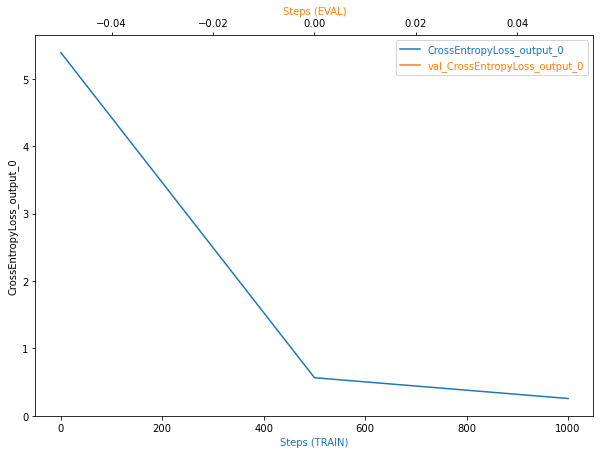

In [14]:
# plot training and validation loss curves
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [16]:
tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-314880696898/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-20-15-02-28-050/profiler-output


Profiler data from system is available
[2022-10-20 15:57:59.249 ip-172-16-174-75.ec2.internal:9069 INFO metrics_reader_base.py:134] Getting 51 event files
select events:['total']
select dimens

In [17]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [18]:
! aws s3 ls {rule_output_path} --recursive

2022-10-20 15:55:45     386857 pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-20 15:55:44     236897 pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-20 15:55:40        192 pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-20 15:55:40        200 pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-20 15:55:40       2021 pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-20 15:55:40        127 pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-20 15:55:40        199 pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-re

In [19]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-20-15-02-28-050/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-20-15

In [20]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [21]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [26]:
model_data= 's3://sagemaker-us-east-1-314880696898/pytorch-training-2022-10-20-15-02-28-050/output/model.tar.gz'

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class dogImagePredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( dogImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )

In [27]:
# Deploy your model to an endpoint

#Add your deployment configuration like instance type and number of instances
# TODO: Add your deployment configuration like instance type and number of instances
pytorch_model = PyTorchModel(model_data=model_data, role=role, entry_point='deploy.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=dogImagePredictor) 

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 

------!

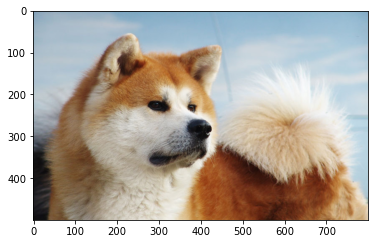

In [15]:
import matplotlib.pyplot as plt

img = plt.imread("./dogImages/test/004.Akita/Akita_00263.jpg")
plt.imshow(img)

In [16]:
import io
from PIL import Image

buffer = io.BytesIO()
Image.open("dogImages/test/004.Akita/Akita_00263.jpg").save(buffer, format="JPEG")
image = buffer.getvalue()

In [28]:
# Run an prediction on the endpoint

response = predictor.predict(image)

In [31]:
argmax(response, 1)

NameError: name 'argmax' is not defined

Test image no: 1
Below is the image that we will be testing:


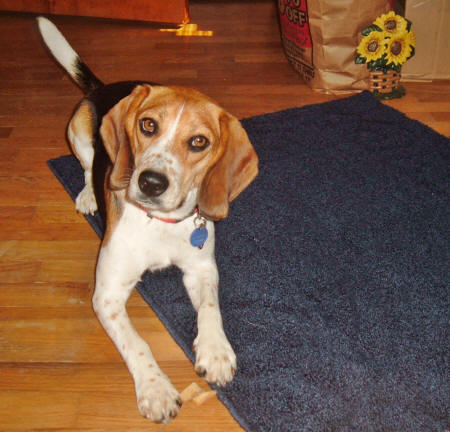

Expected dog breed number: 16


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2022-10-22-14-14-06-727 in account 314880696898 for more information.

In [18]:
# TODO: Run an prediction on the endpoint
# Using the Predictor object directly to evaluate breed
# adapted from udacity forum
from PIL import Image
import io
import os
import numpy as np

test_dir = "./dogImages/test/"
test_images = [ "016.Beagle/Beagle_01130.jpg", '011.Australian_cattle_dog/Australian_cattle_dog_00727.jpg', '025.Black_and_tan_coonhound/Black_and_tan_coonhound_01789.jpg' ]
test_images_expected_output = [16, 11, 25]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed number: {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #index starts in 0 and breeds start in 1
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [23]:
# delete your endpoint once your work is done
predictor.delete_endpoint()